# Perform Sanity-Check of EOR-GRF visibility sims before chunking

In this notebook, we check the EOR-GRF sims to ensure they have the correct power spectrum for a selection of baselines.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import sys
import pyuvdata
import matplotlib.pyplot as plt
import hera_pspec as hp
import h5py
from pyuvdata.uvdata import FastUVH5Meta
import copy
from tqdm import tqdm_notebook

sys.path.append("..")
from core import eor_utils, utils


In [43]:
# DEFAULT PARAMETERS
SKY_MODEL: str = "eor-grf-1024"
PREFIX: str = "final"
CHUNKS: int = 1
LAYOUT: str = "FULL"
REDUNDANT: bool = True

POWER_SPECTRAL_IDX = 0  # Re-adjustment of pspec index to keep SNR constant

BASELINES_TO_INSPECT: list[tuple[int,int]] = [
    (0, 1),
    (0, 2),
    (0, 4),
    (0, 11),
    (0, 23),
    (0, 52),
    (155, 175), # Long EW baseline
    (0, 308),  # long NS baseline
]

# The following should divide 17280 evenly.
EVERY_NTH_TIME: int = 180
BAND: tuple[int, int] = (500, 650)

## Setup

In [4]:
direc = utils.OUTDIR / utils.get_direc(SKY_MODEL, CHUNKS, LAYOUT, REDUNDANT, PREFIX)
files = sorted(direc.glob("*.uvh5"))

# # down-select to specified band
files = [fl for fl in files if BAND[0] <= utils.parse_fname(fl.stem)['fch'] < BAND[1]]

In [5]:
meta = FastUVH5Meta(files[0])

In [6]:
blidx = np.array([meta.antpairs.index(p) if p in meta.antpairs else meta.antpairs.index(p[::-1]) for p in BASELINES_TO_INSPECT])

sorter = np.argsort(blidx)
blidx = blidx[sorter]
BASELINES_TO_INSPECT = [BASELINES_TO_INSPECT[i] for i in sorter]

In [44]:
NTIMES = 17280 // EVERY_NTH_TIME

## Obtain Power Spectrum Definition

In [7]:
cosmo = eor_utils.get_planck15_cosmo()

In [8]:
# Load beam-dependent normalization data
omegas_data_path = utils.BEAMDIR / 'vivaldi_solid_angle_and_reciever_power.h5'

with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['directivity_integral'][()]
    Omegapp = h5f['directivity_square_integral'][()]
    
# hera_pspec beam initiated from pre-computed integral data
hpsb = hp.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, utils.FREQS_DICT['H4C'], cosmo=cosmo)

In [9]:
pspec_def = eor_utils.get_pspec_from_covariance_file(utils.SKYDIR / 'raw' / 'covariance.h5')

## Read Data

In [10]:
pyuvdata_nocheck = {
    'run_check': False,
    'check_extra': False,
    'run_check_acceptability': False,
    'strict_uvw_antpos_check': False,
    'check_autos': False,
    'fix_autos': False
}

We read only a single time-stamp here, and only the baselines we care about. This dramatically speeds up reading.

In [46]:
blt_idx = np.concatenate([blidx + i*meta.Nbls*EVERY_NTH_TIME for i in range(NTIMES)])

In [48]:
%%time
uvd = pyuvdata.UVData.from_file(files[0], blt_inds=blt_idx, **pyuvdata_nocheck)

antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.


CPU times: user 4.8 s, sys: 2.82 s, total: 7.62 s
Wall time: 15.1 s


In [49]:
uvd.freq_array = utils.FREQS_DICT['H4C'][BAND[0]:BAND[1]]

dd = uvd.data_array.copy()

uvd.data_array = np.zeros((dd.shape[0], BAND[1] - BAND[0], dd.shape[2]), dtype=complex)
uvd.data_array[:, 0, :] = dd[:, 0]

# Re-set arrays that reference Nfreqs
uvd.nsample_array = np.ones(uvd.data_array.shape, dtype=float)
uvd.flag_array = np.zeros(uvd.data_array.shape, dtype=bool)
uvd.Nfreqs = BAND[1] - BAND[0]
uvd.channel_width = np.ones(BAND[1] - BAND[0]) * (uvd.freq_array[1] - uvd.freq_array[0])
uvd.flex_spw_id_array = np.zeros(BAND[1] - BAND[0], dtype=int)

In [50]:
%%time
for i, fl in enumerate(files[1:]):
    with h5py.File(fl, 'r') as _fl:
        dd = _fl['Data']['visdata'][blt_idx, 0, :]
        uvd.data_array[:, i] = dd

CPU times: user 8.98 s, sys: 1min 4s, total: 1min 13s
Wall time: 21min 26s


In [51]:
uvd.check()

True

## Compute Power Spectra from Data

In [52]:
uvd_pstokes = hp.pstokes.construct_pstokes(uvd, uvd, pstokes='pI', run_check=False)
ds = hp.PSpecData(dsets=[uvd_pstokes, uvd_pstokes], beam=hpsb)
ds.Jy_to_mK()

No polarization convention in uvd1. Considering it to be "avg".
No polarization convention in uvd2. Considering it to be "avg".
Cannot convert dset 1 Jy -> mK because vis_units = mK


In [53]:
ant_pairs = [ant_pair for ant_pair in uvd.get_antpairs() if ant_pair[0] != ant_pair[1]]
spw_ranges = [(0, BAND[1] - BAND[0])] # use the full band, since we already down-selected

uvp = ds.pspec(
    ant_pairs, ant_pairs,
    dsets=(0,1),
    pols=('pI', 'pI'),
    input_data_weight='identity',
    norm='I',
    taper='blackman-harris',
    spw_ranges=spw_ranges,
    store_window=False,
    verbose=True,
    allow_fft=True,
    exact_norm=False
)

# time average for each (delay, baseline)
uvp.average_spectra(time_avg=True, inplace=True)

In [54]:
k_bin_widths = 0.05
k_bins = np.arange(0,2.0,k_bin_widths)

In [55]:
%%time

uvp_sphr = copy.deepcopy(uvp)

# average over (delay, baseline) for each k
uvp_sphr = hp.grouping.spherical_average(uvp_sphr, k_bins, k_bin_widths, run_check=False)

CPU times: user 23.3 ms, sys: 727 μs, total: 24.1 ms
Wall time: 18.2 ms


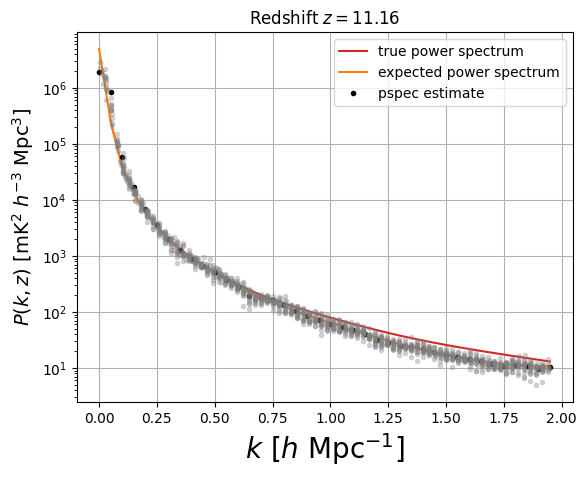

In [56]:
littleh = True
key = uvp_sphr.get_all_keys()[0]

z_mean = np.mean(eor_utils.get_zs(cosmo, uvp, 0))

pspec_true = eor_utils.true_power_spectrum(cosmo, pspec_def, k_bins[1:], z_mean, rescale_idx=POWER_SPECTRAL_IDX, littleh=littleh)
pspec_expected = eor_utils.expected_power_spectrum(cosmo, pspec_def, k_bins, uvp, spw=0, rescale_idx=POWER_SPECTRAL_IDX, littleh=littleh)

plt.plot(k_bins[1:], pspec_true, label='true power spectrum', color='tab:red')
plt.plot(k_bins, pspec_expected, label='expected power spectrum', color='tab:orange')

# The average over all baselines
pspec_est = uvp_sphr.get_data(key)[0].real
plt.plot(k_bins, pspec_est*4, 'o.x'[i%3], label=f'pspec estimate', color='k')

# Each baseline
for i, key in enumerate(uvp.get_all_keys()):
    kmag = np.sqrt(uvp.get_kparas(0)**2 + uvp.get_kperps(0)[i]**2)
    d = uvp.get_data(key)[0].real
    plt.plot(kmag, d*4, '.', color='gray', alpha=0.3)

plt.yscale('log')
plt.ylabel(r'$P(k,z)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
plt.xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
plt.title(fr'Redshift $z ={z_mean:.2f}$')

plt.grid()
plt.legend();